### Linear Regression Challenge
#### Housing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

from useful.eda import basic_info


basic info for this dataframe...


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43
Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 

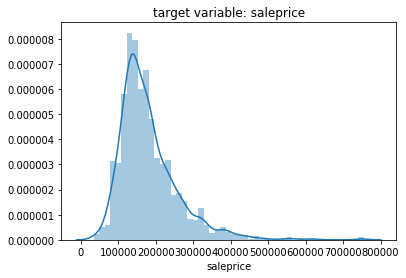

In [3]:
#created a library that spits out basic dataset info to see the code go to: https://github.com/cullinap/useful
basic_info.data_info(house_prices_df,'saleprice')

#### Discussion...

As you can see from the basic info there are a couple important points to take note of...

There are 43 non-numerical columns and 38 numerical columns

The target variable is sales price and has a skewed distribution to the left



### Bivariate Exploration...

#### Non-numeric exploration

There are alot of non-numeric features and we will be looking to put encode them, but we can't do that for every one. 

For the beginning stages I am looking for a feature that has minimal variants and shows difference vs. saleprice. For simplicity sake let's start with some binary non-numeric features that show some differnce between saleprice. From what I can see off the bat we have the features, alley, utilities, centralair, and street. Those will be some good places to start because it keeps our data smallish and they are binary. 

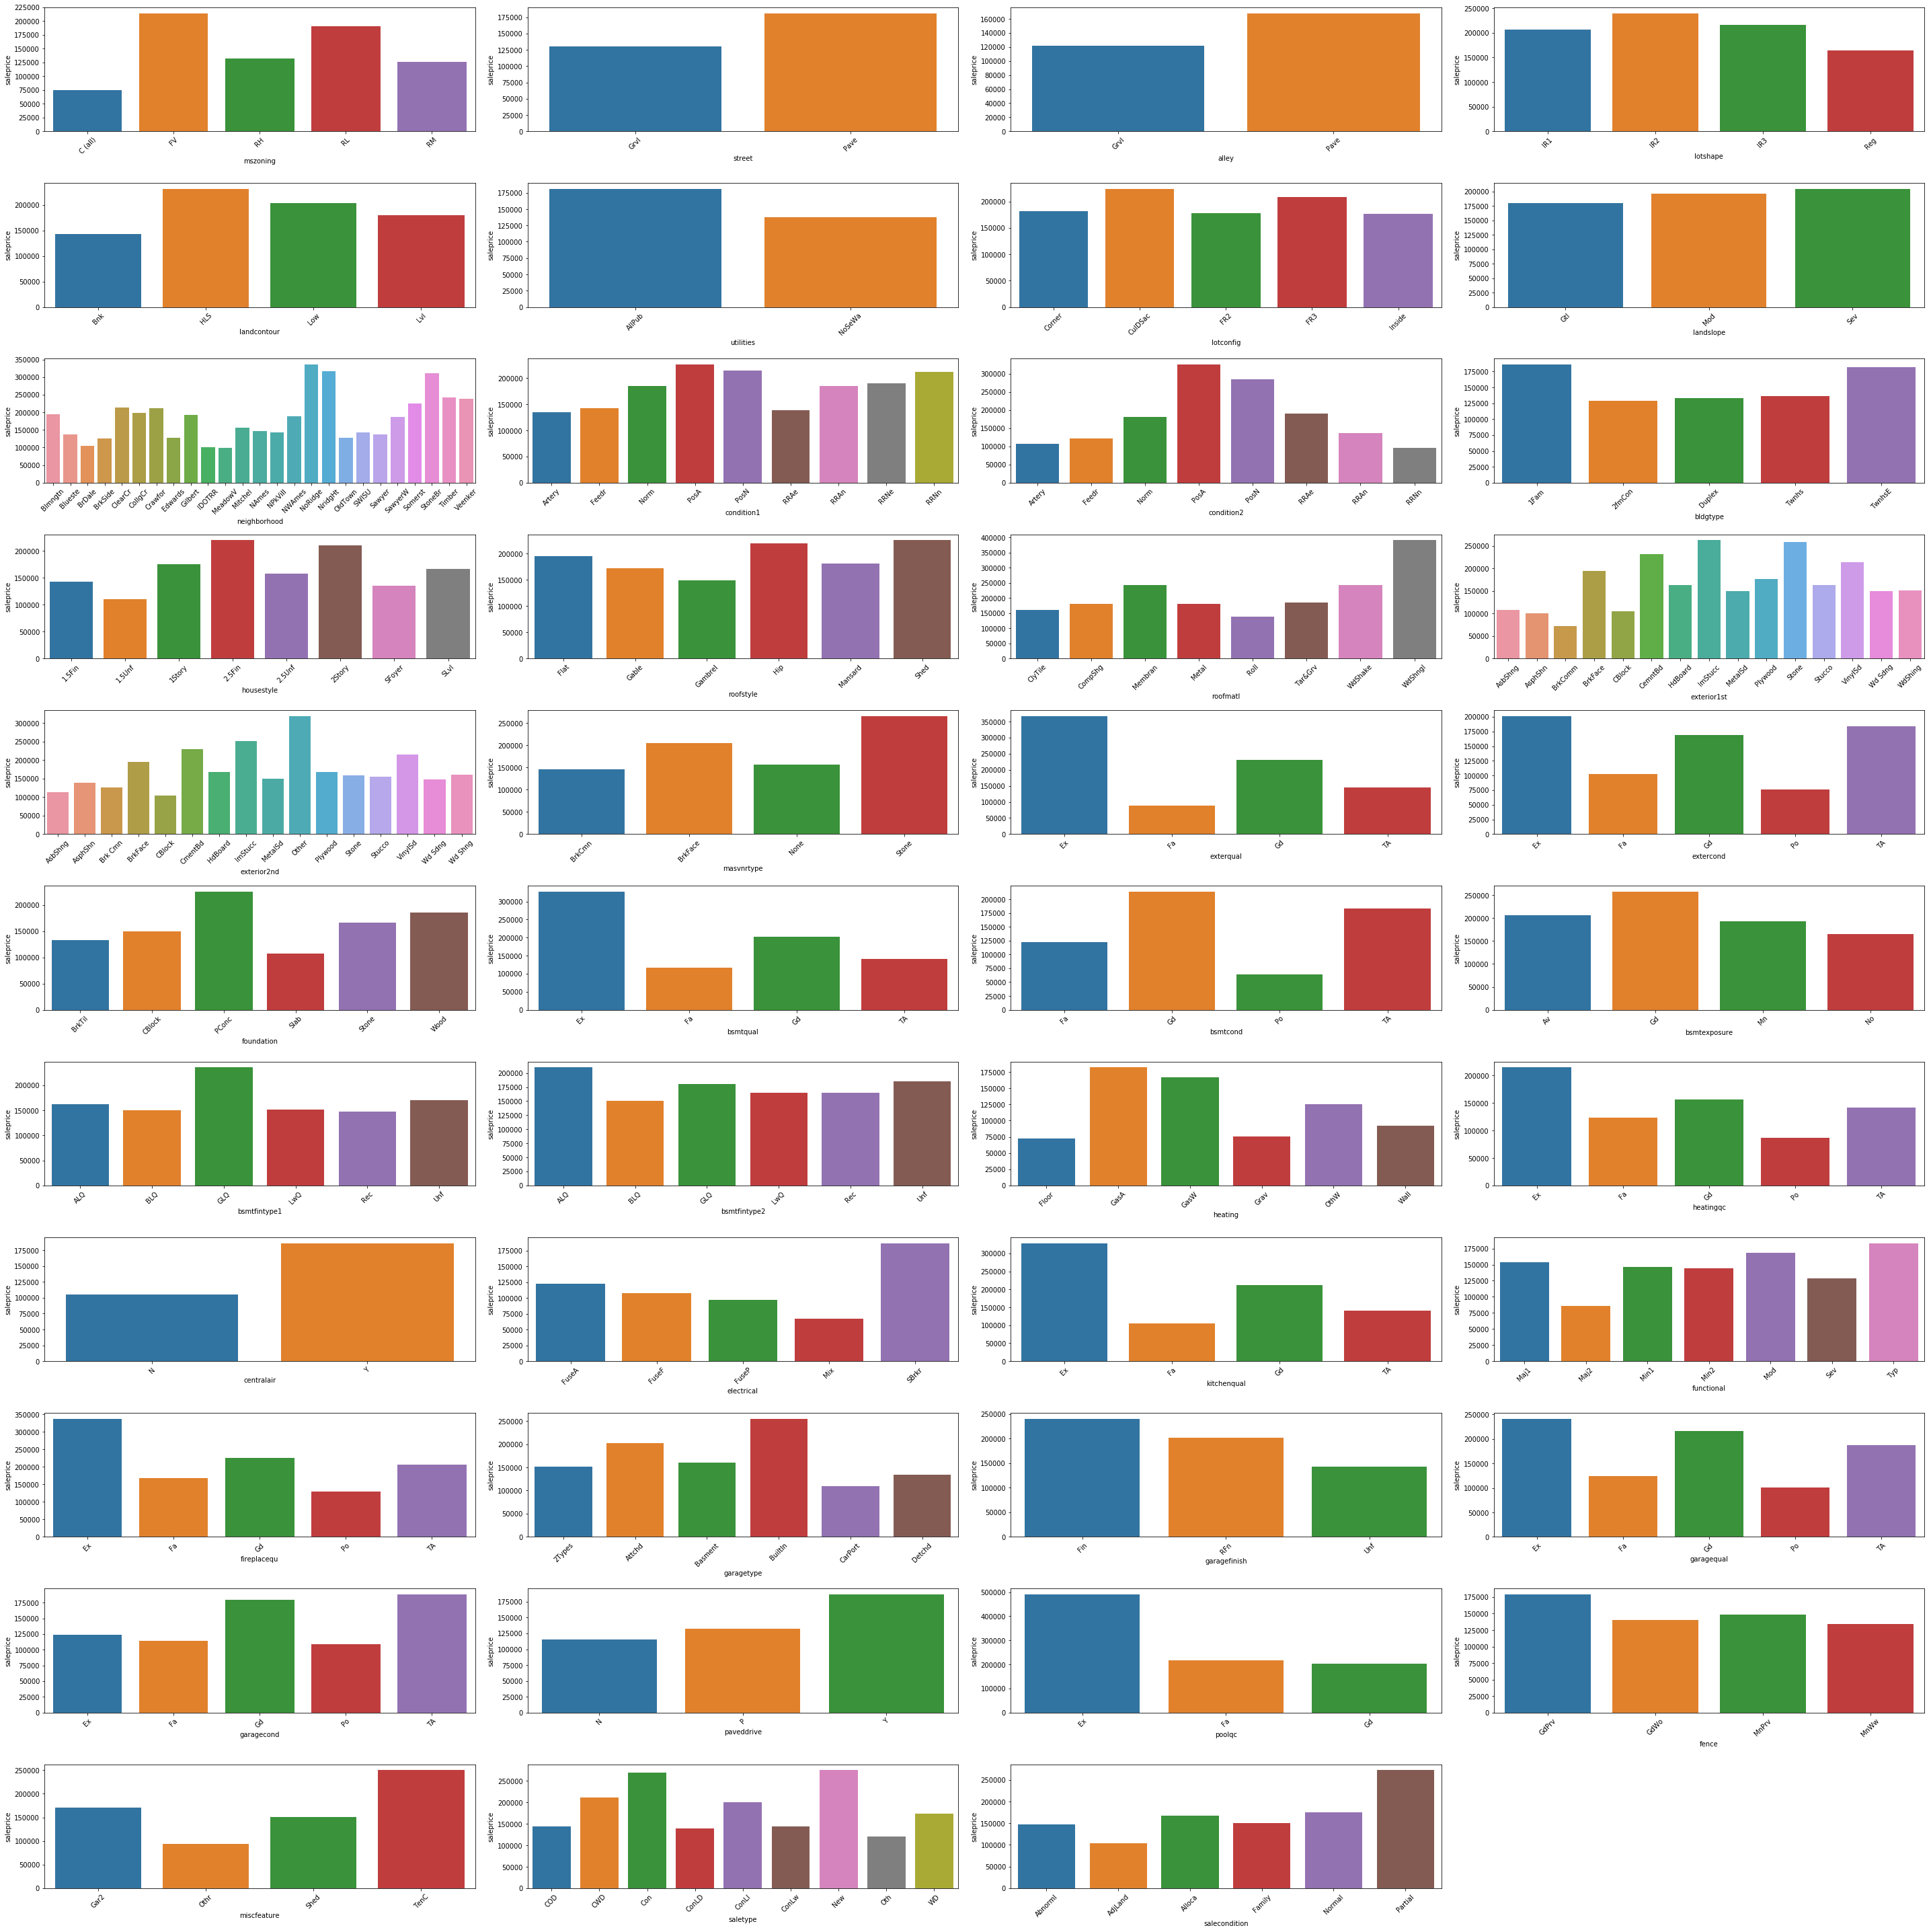

In [4]:
basic_info.non_numeric_feature_corr(house_prices_df, 'saleprice')

##### Numeric Exploration

As above there are alot of numeric features to deal with. Honestly I can't see alot with this map, so I will go with the 4 features from the "top 5 correlated features" in the above list. In addition the top 5 I will keep in mind that garage also seems to have some good correlation, but for now I will just stick with the 4 from the list.

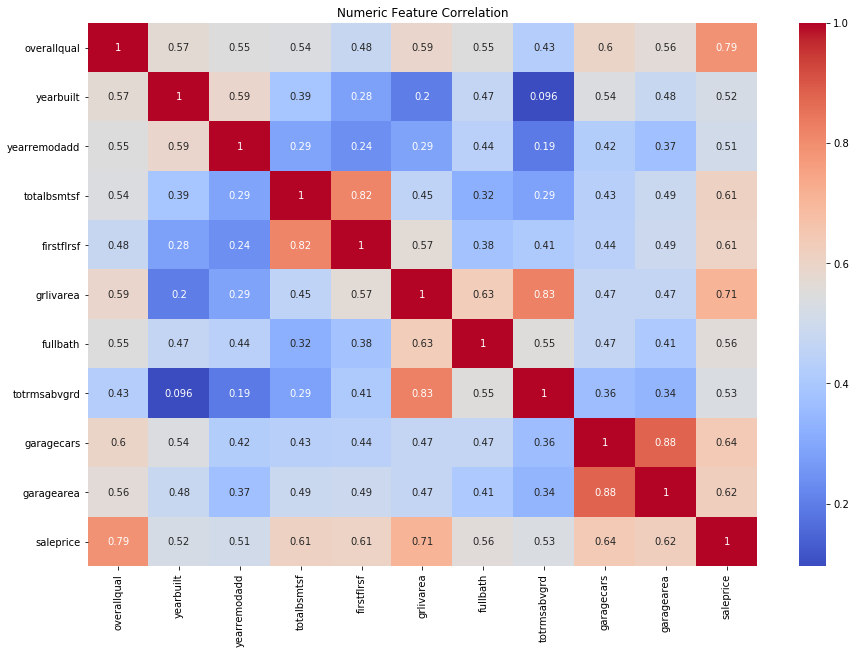

In [5]:
basic_info.numeric_feature_corr(house_prices_df, 
                     target_variable='saleprice',
                     plot='heatmap',
                     corr_cutoff=0.5)

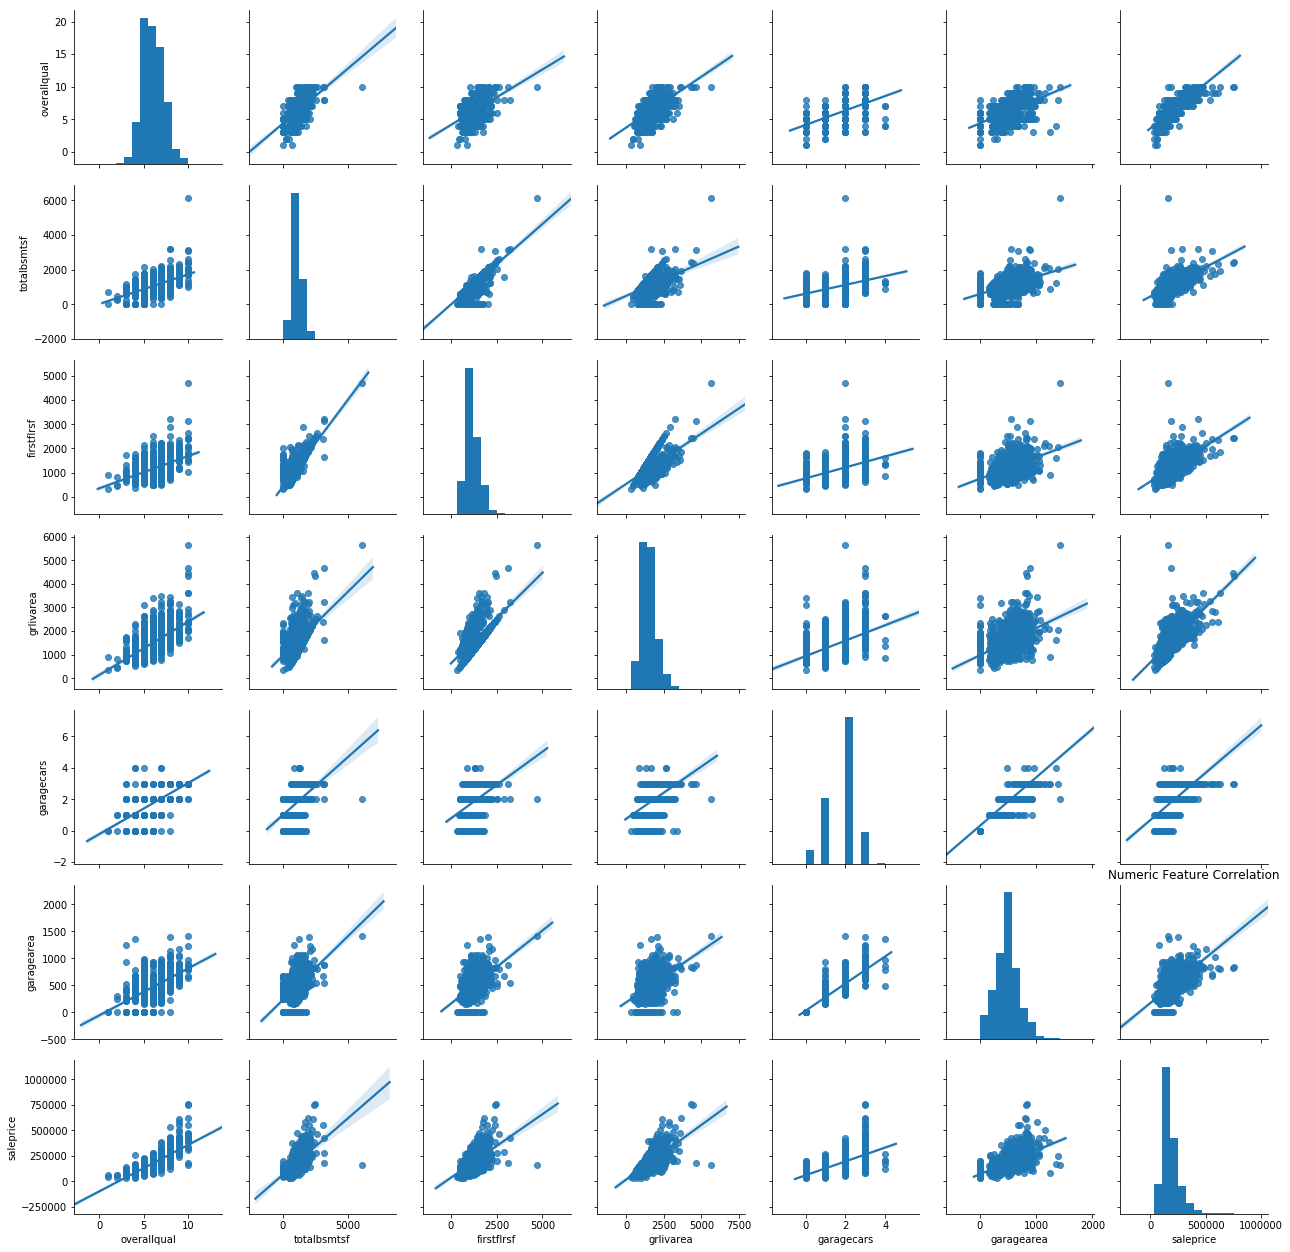

In [6]:
basic_info.numeric_feature_corr(house_prices_df, 
                                target_variable='saleprice',
                                corr_cutoff=0.6)

####  Feature Selection

We will use three techniques to decide upon what features we use: backward elimination, recursive feature elimination, and lasso. The first thing I will do is isolate numeric data so I can throw it into the feature models. Also I want to eliminate the target variable from the input dataset, as well as lotfrontage and garagyrblt as I I don't think it will make much of a difference if they are included or not from the looks of the EDA.

In [417]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_data = house_prices_df.select_dtypes(include=numerics)

In [418]:
X = numeric_data
Y = house_prices_df.saleprice

In [419]:
X = X.drop(['lotfrontage','garageyrblt','saleprice'],axis=1)
X = X.fillna(0)

In [420]:
X.isnull().sum()

id               0
mssubclass       0
lotarea          0
overallqual      0
overallcond      0
yearbuilt        0
yearremodadd     0
masvnrarea       0
bsmtfinsf1       0
bsmtfinsf2       0
bsmtunfsf        0
totalbsmtsf      0
firstflrsf       0
secondflrsf      0
lowqualfinsf     0
grlivarea        0
bsmtfullbath     0
bsmthalfbath     0
fullbath         0
halfbath         0
bedroomabvgr     0
kitchenabvgr     0
totrmsabvgrd     0
fireplaces       0
garagecars       0
garagearea       0
wooddecksf       0
openporchsf      0
enclosedporch    0
threessnporch    0
screenporch      0
poolarea         0
miscval          0
mosold           0
yrsold           0
dtype: int64

##### Backward Elimination

In [414]:
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.01):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['mssubclass', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'totalbsmtsf', 'grlivarea', 'bsmtfullbath', 'bedroomabvgr', 'totrmsabvgrd', 'garagecars', 'wooddecksf', 'screenporch']


##### Recursive Feature Elimination

In [415]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

#no of features
nof_list=np.arange(1,36)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 18
Score with 18 features: 0.742609


In [416]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 10)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)

#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['overallqual', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garagecars'],
      dtype='object')


##### Lasso

In [421]:
reg = LassoCV()
X = X.fillna(0)
#X = X.drop(['saleprice'],axis=1)
reg.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)
print(f"picked {sum(coef != 0)} and eliminated {sum(coef == 0)}")


Best alpha using built-in LassoCV: 209067.774683
Best score using built-in LassoCV: 0.723706
picked 12 and eliminated 23


Text(0.5, 1.0, 'Feature importance using Lasso Model')

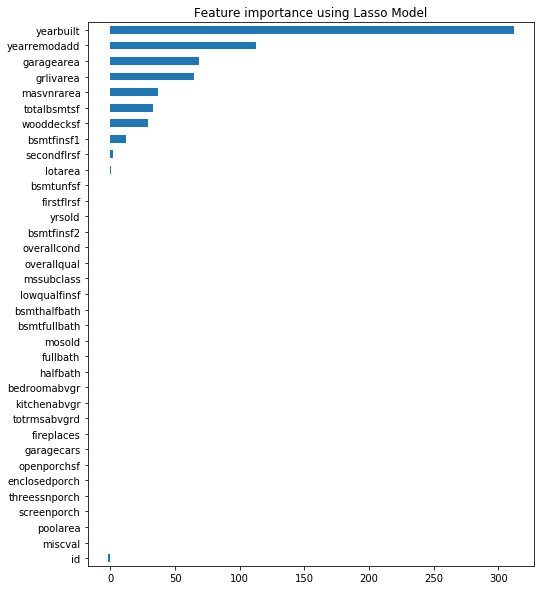

In [422]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Results

These are the resulting column features that each model selected.


##### Model 1: Backward Elimination

In [423]:
be_data = numeric_data.loc[:,[c for c in selected_features_BE]]; be_data.head()

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,totalbsmtsf,grlivarea,bsmtfullbath,bedroomabvgr,totrmsabvgrd,garagecars,wooddecksf,screenporch
0,60,8450,7,5,2003,2003,196.0,706,856,1710,1,3,8,2,0,0
1,20,9600,6,8,1976,1976,0.0,978,1262,1262,0,3,6,2,298,0
2,60,11250,7,5,2001,2002,162.0,486,920,1786,1,3,6,2,0,0
3,70,9550,7,5,1915,1970,0.0,216,756,1717,1,3,7,3,0,0
4,60,14260,8,5,2000,2000,350.0,655,1145,2198,1,4,9,3,192,0


##### Model 2: Recursive Feature Elimination

In [424]:
rfe_data = numeric_data.loc[:,[c for c in selected_features_rfe]]; rfe_data.head()

,overallqual,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garagecars
0,7,1,0,2,1,3,1,8,0,2
1,6,0,1,2,0,3,1,6,1,2
2,7,1,0,2,1,3,1,6,1,2
3,7,1,0,1,0,3,1,7,1,3
4,8,1,0,2,1,4,1,9,1,3


##### Model 3: Lasso Embedded Method

In [425]:
lasso_coef_df = pd.DataFrame(imp_coef)

lasso_df = numeric_data.loc[:,[c for c in lasso_coef_df.index if lasso_coef_df[0][c] != 0]]; lasso_df.head()



,id,miscval,lotarea,secondflrsf,bsmtfinsf1,wooddecksf,totalbsmtsf,masvnrarea,grlivarea,garagearea,yearremodadd,yearbuilt
0,1,0,8450,854,706,0,856,196.0,1710,548,2003,2003
1,2,0,9600,0,978,298,1262,0.0,1262,460,1976,1976
2,3,0,11250,866,486,0,920,162.0,1786,608,2002,2001
3,4,0,9550,756,216,0,756,0.0,1717,642,1970,1915
4,5,0,14260,1053,655,192,1145,350.0,2198,836,2000,2000


##### Selecting my own features

I will pull the most highly correlated features from the heatmap for this just to see if I can produce a better score

#### Create Dummy Columns

Based on what I did above I will create some dummy variables for the list I created above

In [196]:
non_numeric_columns = ['street', 'alley', 'utilities', 'centralair']
non_numeric_df = house_prices_df.loc[:,non_numeric_columns]; non_numeric_df.head()

,street,alley,utilities,centralair
0,Pave,None,AllPub,Y
1,Pave,None,AllPub,Y
2,Pave,None,AllPub,Y
3,Pave,None,AllPub,Y
4,Pave,None,AllPub,Y


In [63]:
non_numeric_dummies = pd.get_dummies(non_numeric_df,drop_first=True); non_numeric_dummies.head()

,street_Pave,alley_Pave,utilities_NoSeWa,centralair_Y
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1


#### Model 1: Lasso

#####  Preprocessing: Make the X & Y values, Split, Add the constant

In [355]:
#drop features
# lasso_df = lasso_df.drop(['garageyrblt'],axis=1)
lasso_df = lasso_df.fillna(0)

#make X & Y values concat w/dummies
X = pd.concat([lasso_df, non_numeric_dummies], axis=1)
Y = house_prices_df.saleprice

#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


#add constant
X_train = sm.add_constant(X_train); X_train.head()

,const,id,miscval,lotarea,secondflrsf,bsmtfinsf1,wooddecksf,totalbsmtsf,masvnrarea,grlivarea,garagearea,yearremodadd,yearbuilt,street_Pave,alley_Pave,utilities_NoSeWa,centralair_Y
151,1.0,151,0,10356,0,716,0,969,0.0,969,440,1975,1975,1,0,0,1
262,1.0,262,0,9588,1092,0,0,1482,270.0,2574,868,2007,2007,1,0,0,1
1037,1.0,1038,0,9240,1208,0,0,1055,396.0,2263,905,2002,2001,1,0,0,1
1183,1.0,1184,0,10800,0,821,229,1120,0.0,1130,720,1950,1920,1,0,0,1
933,1.0,934,0,8487,0,20,192,1500,210.0,1500,570,2004,2004,1,0,0,1


In [356]:
X_train.isnull().sum()

const               0
id                  0
miscval             0
lotarea             0
secondflrsf         0
bsmtfinsf1          0
wooddecksf          0
totalbsmtsf         0
masvnrarea          0
grlivarea           0
garagearea          0
yearremodadd        0
yearbuilt           0
street_Pave         0
alley_Pave          0
utilities_NoSeWa    0
centralair_Y        0
dtype: int64

#### Run the model - Regular 'ol Linear Regression

In [357]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     198.8
Date:                Mon, 30 Sep 2019   Prob (F-statistic):          3.07e-317
Time:                        19:19:49   Log-Likelihood:                -14052.
No. Observations:                1168   AIC:                         2.814e+04
Df Residuals:                    1151   BIC:                         2.822e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.036e+06   1.37e+05  

##### Predict

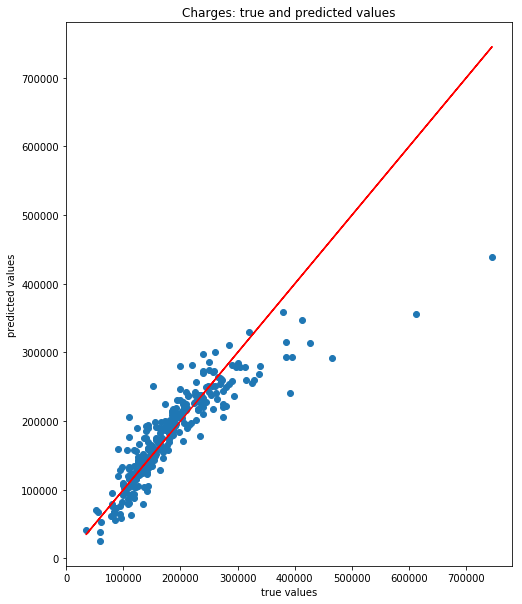

Mean absolute error of the prediction is: 23584.785802409468
Mean squared error of the prediction is: 1538295868.6065502
Root mean squared error of the prediction is: 39221.11508622046
Mean absolute percentage error of the prediction is: 13.03145861873189


In [358]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

#add the constant use the parameter has_constant to force constant because sometimes it thinks there is constant already
X_test = sm.add_constant(X_test, has_constant='add')

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


#### Use CV to find the best alpha

In [359]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

##### Elasticnet CV

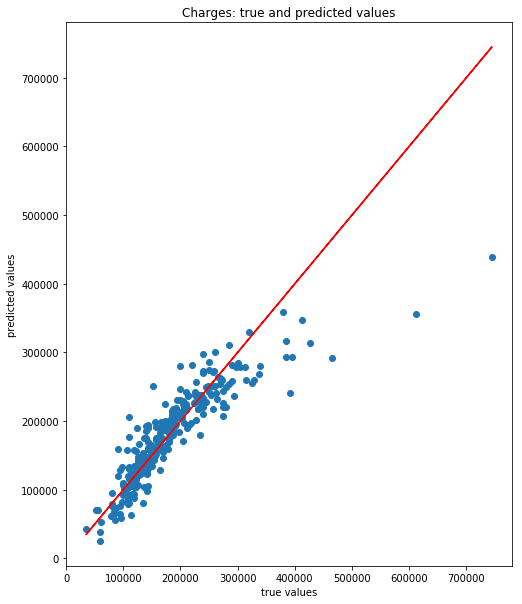

Best alpha value is: 0.001
R^2 train 0.7342280530414529
-test stats-
R^2 test 0.7708974749330251
MAE prediction 23598.527245425576
MSE prediction 1538126557.0681696
RMSE prediction 39218.95660351215
MA%E prediction 182129.4755126924


In [360]:
from sklearn.linear_model import ElasticNetCV

ElasticNetregrCV = ElasticNetCV(alphas=alphas, cv=5)
ElasticNetregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = ElasticNetregrCV.predict(X_train)
y_preds_test = ElasticNetregrCV.predict(X_test)

#y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ElasticNetregrCV.alpha_))
print(f"R^2 train {ElasticNetregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {ElasticNetregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

#### Lasso CV

In [361]:
from sklearn.linear_model import LassoCV

LassoregrCV = LassoCV(alphas=alphas, cv=5)
LassoregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = LassoregrCV.predict(X_train)
y_preds_test = LassoregrCV.predict(X_test)

print("Best alpha value is: {}".format(LassoregrCV.alpha_))
print(f"R^2 train {LassoregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {LassoregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 10.0
R^2 train 0.7342245959155138
-test stats-
R^2 test 0.770956733393724
MAE prediction 23590.54799728107
MSE prediction 1537728713.2988555
RMSE prediction 39213.8841904096
MA%E prediction 182130.6254661598


#### Ridge CV

In [362]:
from sklearn.linear_model import RidgeCV

RidgeregrCV = RidgeCV(alphas=alphas, cv=5)
RidgeregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = RidgeregrCV.predict(X_train)
y_preds_test = RidgeregrCV.predict(X_test)

print("Best alpha value is: {}".format(RidgeregrCV.alpha_))
print(f"R^2 train {RidgeregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {RidgeregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 1.0
R^2 train 0.7342061294547619
-test stats-
R^2 test 0.7708868068834743
MAE prediction 23607.17151096244
MSE prediction 1538198179.1959555
RMSE prediction 39219.869698865085
MA%E prediction 182128.61522661467


#### Model #2: Backward Elimination

In [444]:
be_data_X = be_data.copy()

#drop features
#be_data_X = be_data.drop(['garageyrblt'],axis=1)
be_data_X = be_data_X.fillna(0)

#make X & Y values concat w/dummies
X = pd.concat([be_data_X, non_numeric_dummies], axis=1)
Y = house_prices_df.saleprice

#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test); X_train.head()

,const,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,totalbsmtsf,...,bsmtfullbath,bedroomabvgr,totrmsabvgrd,garagecars,wooddecksf,screenporch,street_Pave,alley_Pave,utilities_NoSeWa,centralair_Y
151,1.0,20,10356,5,6,1975,1975,0.0,716,969,...,0,3,5,2,0,0,1,0,0,1
262,1.0,60,9588,8,5,2007,2007,270.0,0,1482,...,0,3,10,3,0,0,1,0,0,1
1037,1.0,60,9240,8,5,2001,2002,396.0,0,1055,...,0,3,7,2,0,189,1,0,0,1
1183,1.0,30,10800,5,6,1920,1950,0.0,821,1120,...,1,2,5,2,229,0,1,0,0,1
933,1.0,20,8487,7,5,2004,2004,210.0,20,1500,...,0,3,6,2,192,0,1,0,0,1


##### Linear Regression

In [445]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     243.4
Date:                Tue, 01 Oct 2019   Prob (F-statistic):               0.00
Time:                        07:40:40   Log-Likelihood:                -13858.
No. Observations:                1168   AIC:                         2.776e+04
Df Residuals:                    1147   BIC:                         2.786e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.142e+06   1.33e+05  

##### ElasticnetCV

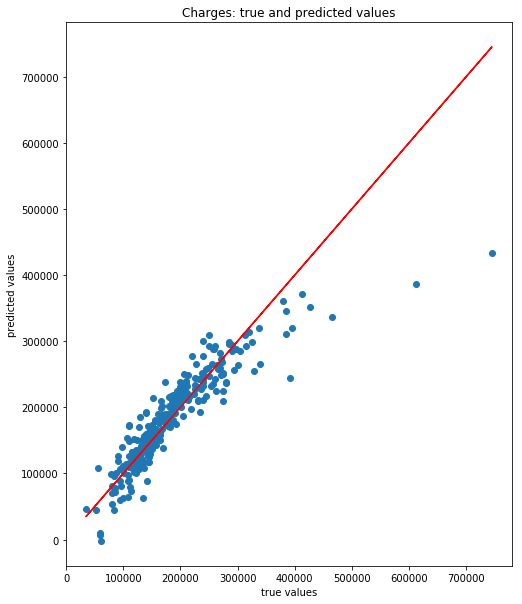

Best alpha value is: 0.1
R^2 train 0.8079884702373874
-test stats-
R^2 test 0.8068447855166195
MAE prediction 21884.87737362559
MSE prediction 1296786951.3713722
RMSE prediction 36010.92822146317
MA%E prediction 183227.4743613505


In [446]:
from sklearn.linear_model import ElasticNetCV

ElasticNetregrCV = ElasticNetCV(alphas=alphas, cv=5)
ElasticNetregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = ElasticNetregrCV.predict(X_train)
y_preds_test = ElasticNetregrCV.predict(X_test)

#y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ElasticNetregrCV.alpha_))
print(f"R^2 train {ElasticNetregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {ElasticNetregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

##### Lasso

In [447]:
from sklearn.linear_model import LassoCV

LassoregrCV = LassoCV(alphas=alphas, cv=5)
LassoregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = LassoregrCV.predict(X_train)
y_preds_test = LassoregrCV.predict(X_test)

print("Best alpha value is: {}".format(LassoregrCV.alpha_))
print(f"R^2 train {LassoregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {LassoregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 100.0
R^2 train 0.8085518370059354
-test stats-
R^2 test 0.8047966772563819
MAE prediction 22206.131077858714
MSE prediction 1310537344.1525133
RMSE prediction 36201.34450752504
MA%E prediction 183329.37215692963


##### Ridge

In [448]:
from sklearn.linear_model import RidgeCV

RidgeregrCV = RidgeCV(alphas=alphas, cv=5)
RidgeregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = RidgeregrCV.predict(X_train)
y_preds_test = RidgeregrCV.predict(X_test)

print("Best alpha value is: {}".format(RidgeregrCV.alpha_))
print(f"R^2 train {RidgeregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {RidgeregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 10.0
R^2 train 0.8087341326309575
-test stats-
R^2 test 0.8048126854261924
MAE prediction 22192.844349640778
MSE prediction 1310429870.0375583
RMSE prediction 36199.86008312129
MA%E prediction 183333.45098397083


##### Model #3: Recursive Elimination

In [451]:
rfe_data_X = rfe_data.copy()

#drop features
#be_data_X = be_data.drop(['garageyrblt'],axis=1)
rfe_data_X = rfe_data_X.fillna(0)

#make X & Y values concat w/dummies
X = pd.concat([rfe_data_X, non_numeric_dummies], axis=1)
Y = house_prices_df.saleprice

#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test); X_train.head()

,const,overallqual,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garagecars,street_Pave,alley_Pave,utilities_NoSeWa,centralair_Y
151,1.0,5,0,0,1,1,3,1,5,0,2,1,0,0,1
262,1.0,8,0,0,2,1,3,1,10,1,3,1,0,0,1
1037,1.0,8,0,0,2,1,3,1,7,1,2,1,0,0,1
1183,1.0,5,1,0,1,0,2,1,5,1,2,1,0,0,1
933,1.0,7,0,0,2,0,3,1,6,0,2,1,0,0,1


In [452]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     260.0
Date:                Tue, 01 Oct 2019   Prob (F-statistic):               0.00
Time:                        07:42:37   Log-Likelihood:                -13993.
No. Observations:                1168   AIC:                         2.802e+04
Df Residuals:                    1153   BIC:                         2.809e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9.831e+04   1.97e+04  

##### ElasticCV

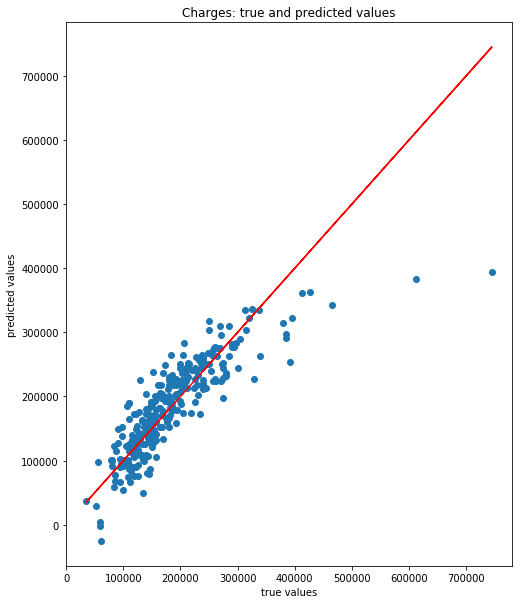

Best alpha value is: 0.01
R^2 train 0.7591341716192583
-test stats-
R^2 test 0.7221638704208957
MAE prediction 29217.06966209409
MSE prediction 1865309556.4692035
RMSE prediction 43189.229635051415
MA%E prediction 184088.52689942557


In [453]:
from sklearn.linear_model import ElasticNetCV

ElasticNetregrCV = ElasticNetCV(alphas=alphas, cv=5)
ElasticNetregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = ElasticNetregrCV.predict(X_train)
y_preds_test = ElasticNetregrCV.predict(X_test)

#y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ElasticNetregrCV.alpha_))
print(f"R^2 train {ElasticNetregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {ElasticNetregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

##### Lasso

In [454]:
from sklearn.linear_model import LassoCV

LassoregrCV = LassoCV(alphas=alphas, cv=5)
LassoregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = LassoregrCV.predict(X_train)
y_preds_test = LassoregrCV.predict(X_test)

print("Best alpha value is: {}".format(LassoregrCV.alpha_))
print(f"R^2 train {LassoregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {LassoregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 10.0
R^2 train 0.7594414610636895
-test stats-
R^2 test 0.7236027658777652
MAE prediction 29192.144918856084
MSE prediction 1855649238.1710594
RMSE prediction 43077.2473374409
MA%E prediction 184117.61809484087


##### Ridge

In [455]:
from sklearn.linear_model import RidgeCV

RidgeregrCV = RidgeCV(alphas=alphas, cv=5)
RidgeregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = RidgeregrCV.predict(X_train)
y_preds_test = RidgeregrCV.predict(X_test)

print("Best alpha value is: {}".format(RidgeregrCV.alpha_))
print(f"R^2 train {RidgeregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {RidgeregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 10.0
R^2 train 0.7589656266225102
-test stats-
R^2 test 0.7211266875406752
MAE prediction 29235.136894211893
MSE prediction 1872272895.4028845
RMSE prediction 43269.768839258715
MA%E prediction 184073.1547343109


##### Method # 4 picking data from the heatmap

In [482]:
X_heatmap = house_prices_df[['overallqual','totalbsmtsf','firstflrsf','grlivarea','garagecars','garagearea']]

#make X & Y values concat w/dummies
X = pd.concat([X_heatmap, non_numeric_dummies], axis=1)
Y = house_prices_df.saleprice

#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test); X_train.head()

,const,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea,street_Pave,alley_Pave,utilities_NoSeWa,centralair_Y
151,1.0,5,969,969,969,2,440,1,0,0,1
262,1.0,8,1482,1482,2574,3,868,1,0,0,1
1037,1.0,8,1055,1055,2263,2,905,1,0,0,1
1183,1.0,5,1120,1130,1130,2,720,1,0,0,1
933,1.0,7,1500,1500,1500,2,570,1,0,0,1


In [483]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     371.5
Date:                Tue, 01 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:31:48   Log-Likelihood:                -13986.
No. Observations:                1168   AIC:                         2.799e+04
Df Residuals:                    1157   BIC:                         2.805e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.066e+05    1.8e+04  

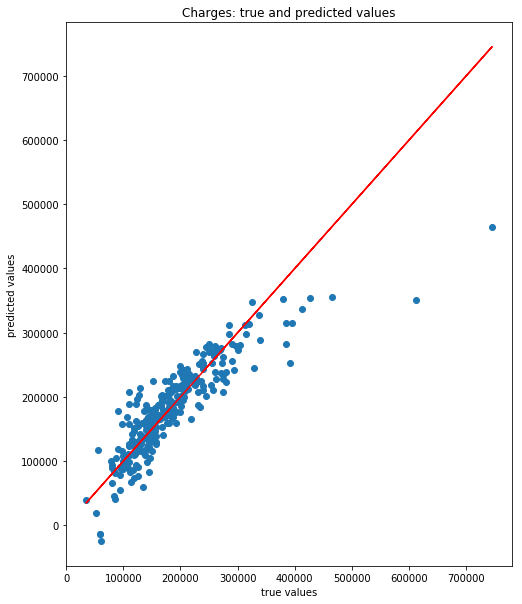

Best alpha value is: 0.01
R^2 train 0.7623262021015124
-test stats-
R^2 test 0.7675902491877552
MAE prediction 25778.73917816421
MSE prediction 1560330292.0446053
RMSE prediction 39501.016341919676
MA%E prediction 182760.80036175007


In [484]:
from sklearn.linear_model import ElasticNetCV

ElasticNetregrCV = ElasticNetCV(alphas=alphas, cv=5)
ElasticNetregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = ElasticNetregrCV.predict(X_train)
y_preds_test = ElasticNetregrCV.predict(X_test)

#y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ElasticNetregrCV.alpha_))
print(f"R^2 train {ElasticNetregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {ElasticNetregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

In [485]:
from sklearn.linear_model import LassoCV

LassoregrCV = LassoCV(alphas=alphas, cv=5)
LassoregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = LassoregrCV.predict(X_train)
y_preds_test = LassoregrCV.predict(X_test)

print("Best alpha value is: {}".format(LassoregrCV.alpha_))
print(f"R^2 train {LassoregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {LassoregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 10.0
R^2 train 0.7624773788268419
-test stats-
R^2 test 0.7673869855772903
MAE prediction 25813.030438500828
MSE prediction 1561694943.7753096
RMSE prediction 39518.286194815046
MA%E prediction 182783.3309968655


In [486]:
from sklearn.linear_model import RidgeCV

RidgeregrCV = RidgeCV(alphas=alphas, cv=5)
RidgeregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = RidgeregrCV.predict(X_train)
y_preds_test = RidgeregrCV.predict(X_test)

print("Best alpha value is: {}".format(RidgeregrCV.alpha_))
print(f"R^2 train {RidgeregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {RidgeregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 10.0
R^2 train 0.7622515108283227
-test stats-
R^2 test 0.767745642755546
MAE prediction 25753.5974709807
MSE prediction 1559287025.6146655
RMSE prediction 39487.80856941374
MA%E prediction 182748.89972857665


##### Scaling/normalizing: Backward Elimination

Let's try to transform the data a bit to improve performance. I will use standard scaler for the input variables and log normalization for the output variable.

In [494]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

be_data_X_norm = be_data.copy()
names = be_data_X_norm.columns
be_data_X_norm = scaler.fit_transform(be_data_X_norm)
be_data_X_norm = pd.DataFrame(be_data_X_norm, columns=names)

be_data_X_norm.head()

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,totalbsmtsf,grlivarea,bsmtfullbath,bedroomabvgr,totrmsabvgrd,garagecars,wooddecksf,screenporch
0,0.073375,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.459303,0.370333,1.107810,0.163779,0.912210,0.311725,-0.752176,-0.270208
1,-0.872563,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,0.466465,-0.482512,-0.819964,0.163779,-0.318683,0.311725,1.626195,-0.270208
2,0.073375,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.313369,0.515013,1.107810,0.163779,-0.318683,0.311725,-0.752176,-0.270208
3,0.309859,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.687324,0.383659,1.107810,0.163779,0.296763,1.650307,-0.752176,-0.270208
4,0.073375,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,0.199680,1.299326,1.107810,1.390023,1.527656,1.650307,0.780197,-0.270208


In [495]:
from sklearn.preprocessing import Imputer

trainDataVecs = Imputer().fit_transform(be_data_X_norm)

be_data_X_norm = pd.DataFrame(trainDataVecs,columns=names)

In [496]:
#make X & Y values concat w/dummies
X = pd.concat([be_data_X_norm, non_numeric_dummies], axis=1)
Y = np.log10(house_prices_df.saleprice)

#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test); X_train.head()

,const,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,totalbsmtsf,...,bsmtfullbath,bedroomabvgr,totrmsabvgrd,garagecars,wooddecksf,screenporch,street_Pave,alley_Pave,utilities_NoSeWa,centralair_Y
151,1.0,-0.872563,-0.016119,-0.795151,0.381743,0.123613,-0.478030,-0.572835,0.597357,-0.201638,...,-0.819964,0.163779,-0.934130,0.311725,-0.752176,-0.270208,1,0,0,1
262,1.0,0.073375,-0.093089,1.374795,-0.517200,1.183477,1.072482,0.918846,-0.973018,0.968112,...,-0.819964,0.163779,2.143103,1.650307,-0.752176,-0.270208,1,0,0,1
1037,1.0,0.073375,-0.127966,1.374795,-0.517200,0.984752,0.830215,1.614964,-0.973018,-0.005540,...,-0.819964,0.163779,0.296763,0.311725,-0.752176,3.120637,1,0,0,1
1183,1.0,-0.636078,0.028380,-0.795151,0.381743,-1.698028,-1.689368,-0.572835,0.827650,0.142674,...,1.107810,-1.062465,-0.934130,0.311725,1.075498,-0.270208,1,0,0,1
933,1.0,-0.872563,-0.203433,0.651479,-0.517200,1.084115,0.927122,0.587362,-0.929153,1.009156,...,-0.819964,0.163779,-0.318683,0.311725,0.780197,-0.270208,1,0,0,1


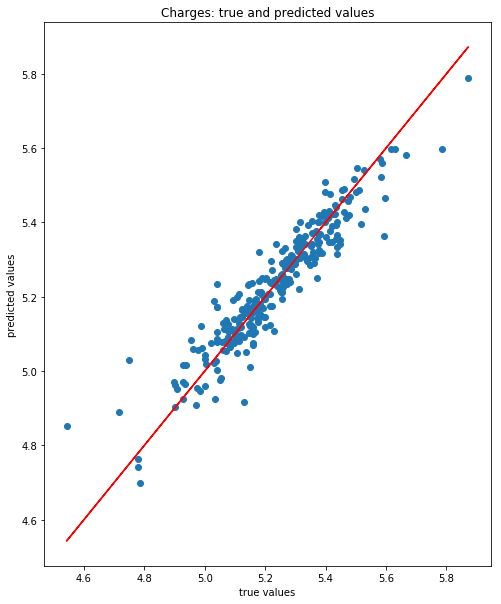

Best alpha value is: 0.001
R^2 train 0.8553681308965098
-test stats-
R^2 test 0.8777098596692755
MAE prediction 0.04383185249191808
MSE prediction 0.0038460984043374746
RMSE prediction 0.062016920306779785
MA%E prediction 5.227566118437888


In [497]:
ElasticNetregrCV = ElasticNetCV(alphas=alphas, cv=5)
ElasticNetregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = ElasticNetregrCV.predict(X_train)
y_preds_test = ElasticNetregrCV.predict(X_test)

#y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ElasticNetregrCV.alpha_))
print(f"R^2 train {ElasticNetregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {ElasticNetregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

##### Lasso

In [498]:
from sklearn.linear_model import LassoCV

LassoregrCV = LassoCV(alphas=alphas, cv=5)
LassoregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = LassoregrCV.predict(X_train)
y_preds_test = LassoregrCV.predict(X_test)

print("Best alpha value is: {}".format(LassoregrCV.alpha_))
print(f"R^2 train {LassoregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {LassoregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

Best alpha value is: 0.0001
R^2 train 0.8559638608282467
-test stats-
R^2 test 0.8775070674075084
MAE prediction 0.043969272362597435
MSE prediction 0.003852476342839176
RMSE prediction 0.062068319961468076
MA%E prediction 5.227527101189006


As you can see there is a 5-7% performance improvement by scaling/log normalization.

##### Method #4 Scaled

In [499]:
X_heatmap = house_prices_df[['overallqual','totalbsmtsf','firstflrsf','grlivarea','garagecars','garagearea']]

scaler = preprocessing.StandardScaler()

X_heatmap_scaled = X_heatmap.copy()
names = X_heatmap_scaled.columns
X_heatmap_scaled = scaler.fit_transform(X_heatmap_scaled)
X_heatmap_scaled = pd.DataFrame(X_heatmap_scaled, columns=names)

Y = house_prices_df.saleprice
Y = np.log10(Y + 1)

X_heatmap_scaled.head()

,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea
0,0.651479,-0.459303,-0.793434,0.370333,0.311725,0.351000
1,-0.071836,0.466465,0.257140,-0.482512,0.311725,-0.060731
2,0.651479,-0.313369,-0.627826,0.515013,0.311725,0.631726
3,0.651479,-0.687324,-0.521734,0.383659,1.650307,0.790804
4,1.374795,0.199680,-0.045611,1.299326,1.650307,1.698485


In [500]:
#make X & Y values concat w/dummies
X = pd.concat([X_heatmap_scaled, non_numeric_dummies], axis=1)
Y = Y

#split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


#add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test); X_train.head()

,const,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea,street_Pave,alley_Pave,utilities_NoSeWa,centralair_Y
151,1.0,-0.795151,-0.201638,-0.501033,-1.040288,0.311725,-0.154306,1,0,0,1
262,1.0,1.374795,0.968112,0.826417,2.015107,1.650307,1.848205,1,0,0,1
1037,1.0,1.374795,-0.005540,-0.278497,1.423064,0.311725,2.021319,1,0,0,1
1183,1.0,-0.795151,0.142674,-0.084426,-0.733797,0.311725,1.155748,1,0,0,1
933,1.0,0.651479,1.009156,0.872994,-0.029438,0.311725,0.453933,1,0,0,1


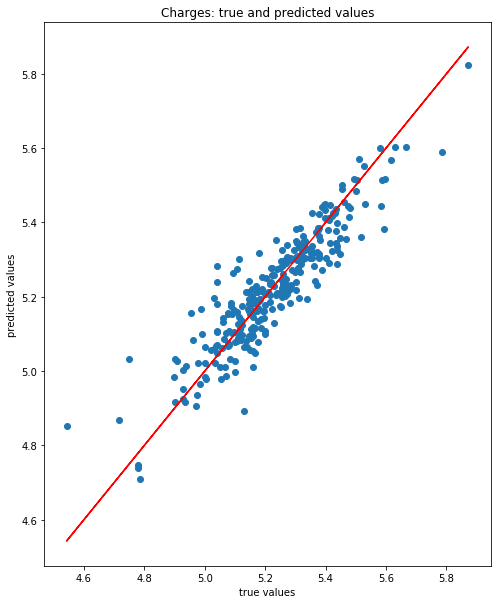

Best alpha value is: 0.001
R^2 train 0.8057175593639923
-test stats-
R^2 test 0.828876858729277
MAE prediction 0.05398262524239018
MSE prediction 0.005381853559648594
RMSE prediction 0.07336111749181984
MA%E prediction 5.225426364646252


In [501]:
ElasticNetregrCV = ElasticNetCV(alphas=alphas, cv=5)
ElasticNetregrCV.fit(X_train, y_train)

#prediction time
y_preds_train = ElasticNetregrCV.predict(X_train)
y_preds_test = ElasticNetregrCV.predict(X_test)

#y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Best alpha value is: {}".format(ElasticNetregrCV.alpha_))
print(f"R^2 train {ElasticNetregrCV.score(X_train, y_train)}")
print("-test stats-")
print(f"R^2 test {ElasticNetregrCV.score(X_test, y_test)}")
print(f"MAE prediction {mean_absolute_error(y_test,y_preds_test)}")
print(f"MSE prediction {mse(y_test, y_preds_test)}")
print(f"RMSE prediction {rmse(y_test, y_preds_test)}")
print(f"MA%E prediction {np.mean(np.abs((y_test, y_preds_test)))}")

##### Summary

Just to recap what happened... 

-We first brought in the dataset and did some prelimary EDA using a correlation matrix and barcharts for
the non-numerical data

-After doing some EDA we picked 4 different non-numerical values based off of their performance in the EDA
and subjected the numerical data to three different tests to find the best features. These tests were
backward elimination, recursive feature elimination, and Lasso to describe feature importance. We then 
took the features that each algorithm gave us and created three different datasets concatenated with 
non-numerical features. For each combined dataset we then ran 4 models, regular linear regression, elasticNet, 
Lasso, and Ridge regression. For Elastic, Lasso, and Ridge we iterated through alphas and allowd he algorithm
to find the best alpha. 

##### What we found...

Backward elimination gave us the best features out of the three methods we tried. After running the backward eliminated data through all 4 models we tried to normalize it to improve accuracy but it looks like we reached the ceiling.

##### Future work...

To continue working through this dataset I would try a few things to improve the model accuracy. First I would most likely look at tuning the features slightly from the backward elimination model. I could do this by adding non-numeric data or combining features. I could try other methods of eliminating outliers and working on improving the fit for the model. I could introduce other machine learning models and techniques, and I could look at boosting the model through something like XGBoost. 

##### What I learned...

I learned that various feature elimination methods provide different results and they are not necessarily better than the others. For example recursive feature elmination performed poorly compared backwards elimination. It seems like RFE provided more categorical data than BE did. Also I could have done just as well choosing features through the correlation matrix as BE. Also I learned that you must make some decisions related to scaling when putting your data through sklearn models. For example sklearn models do not take NaN or inf data and it seems like there are many ways to deal with that could effect the outcome of the model.

The biggest boost in performance overall was log normalizing the saleprice target variable. Once I did that my results jumped from 80% on the ElasticNetCV Backward elimination test set to 87%. So it seems emperically that normalizing the y target in this case dramatically improved the results.